In [ ]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import skimage.io as io
import random
from torch_geometric.data import Data

/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
torch.cuda.is_available()

True

In [ ]:
import numpy as np

def extract_patches(image, cell_coords, patch_size=100):
    """
    Extract image patches centered on given cell coordinates.

    Parameters:
    image (numpy.ndarray): The input image from which patches are to be extracted.
    cell_coords (list of tuples): A list of (x, y) coordinates around which patches are to be extracted.
    patch_size (int, optional): The size of the square patches to be extracted. Default is 100.

    Returns:
    list of numpy.ndarray: A list of extracted image patches, all of the same size.

    Notes:
    - If a patch extends beyond the image border, it will be padded with zeros to match the specified patch size.
    """
    patches = []
    half_size = patch_size // 2
    h, w = image.shape[:2]
    different_shape_count = 0

    # Ensure the input image has 3 dimensions
    if len(image.shape) == 2:  # Grayscale image
        image = image[:, :, np.newaxis]

    for (x, y) in cell_coords:
        x, y = int(x), int(y)
        x_min, x_max = x - half_size, x + half_size
        y_min, y_max = y - half_size, y + half_size

        # Initialize the patch with zeros
        patch = np.zeros((patch_size, patch_size, image.shape[2]), dtype=image.dtype)

        # Calculate bounds for extracting the region from the image
        x_start = max(0, x_min)
        x_end = min(w, x_max)
        y_start = max(0, y_min)
        y_end = min(h, y_max)

        # Calculate where to place the extracted region in the patch
        patch_x_start = max(0, -x_min)
        patch_x_end = patch_x_start + (x_end - x_start)
        patch_y_start = max(0, -y_min)
        patch_y_end = patch_y_start + (y_end - y_start)

        # Assign the extracted region into the patch
        patch[patch_y_start:patch_y_end, patch_x_start:patch_x_end] = image[y_start:y_end, x_start:x_end]

        if patch.shape[:2] != (patch_size, patch_size):
            different_shape_count += 1

        patches.append(patch)

    print(f"Number of patches with different shapes before padding: {different_shape_count}")
    return patches


In [ ]:
def seed_everything(seed=0):
    """Initialize random seeds for reproducibility."""
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    
# Set random seed for reproducibility
random_seed = 0
seed_everything(random_seed)

# Data Preparation

In [ ]:
file_dir = "st_project/cellbin_analysis/spatial_variation/wx_data/"  # Directory containing the data files
files = os.listdir(file_dir)  # List all files in the directory
files = [i for i in files if i.endswith(".h5ad") and "month" in i]  # Filter files to include only those ending with ".h5ad" and containing "month"
file_paths = [os.path.join(file_dir, i) for i in files]  # Create full file paths for the filtered files
adatas = {}  # Initialize an empty dictionary to store AnnData objects

# Read each file and store the AnnData object in the dictionary
for i in range(len(file_paths)):
    adatas[files[i].split(".")[0]] = sc.read(file_paths[i])

# Preprocess each AnnData object
for key in adatas.keys():
    sc.pp.normalize_total(adatas[key], target_sum=1e4)  # Normalize counts per cell
    sc.pp.log1p(adatas[key])  # Logarithmize the data
    sc.pp.scale(adatas[key])  # Scale the data to unit variance

In [ ]:
# Extract spatial coordinates for each cell
cell_coords = {}
for key in adatas.keys():
    cell_coords[key] = adatas[key].obsm["spatial"].copy()
    
# Calculate the neighborhood graph
for key in adatas.keys():
    sc.pp.neighbors(adatas[key], n_neighbors=15, use_rep="spatial", random_state=random_seed)
    
# Extract the spatial neighbors
neighbors = {}
for key in adatas.keys():
    neighbors[key] = adatas[key].obsp["connectivities"].copy()

In [ ]:

# Load the plaque dataset
img_dir = "st_project/cellbin_analysis/spatial_variation/wx_data/protein_seg_result/"
img_files = os.listdir(img_dir)
img_files = [i for i in img_files if i.endswith(".tiff") and "plaque" in i]
# Read the images

imgs = {}
for i in range(len(img_files)):
    imgs[img_files[i].split(".")[0]] = io.imread(os.path.join(img_dir, img_files[i]))
imgs.keys()
# Rename the imgs to match the adata keys
for key in list(imgs.keys()):
    parts = key.split("_")
    if len(parts) > 1:
        new_key = parts[1] + "_" + parts[2]
        imgs[new_key] = imgs.pop(key)



In [ ]:
# Extract patches from the images
patches = {}
for key in imgs.keys():
    patches[key] = extract_patches(imgs[key], cell_coords[key], patch_size=128)

# Extract the positive patches
positive_patches = {}
for key in patches.keys():
    pos_list = []
    for i in range(len(patches[key])):
        if np.sum(patches[key][i]) > 0:
            pos_list.append(patches[key][i])
    positive_patches[key] = pos_list

# Convert the patches to binary and calculate the area of positive pixels for each patch
binary_patches = {}
for key in patches.keys():
    binary_patches[key] = [patch > 0 for patch in patches[key]]
# Calculate the area of positive pixels for each patch
areas = {}
for key in binary_patches.keys():
    areas[key] = [np.sum(patch) for patch in binary_patches[key]]

Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0
Number of patches with different shapes before padding: 0


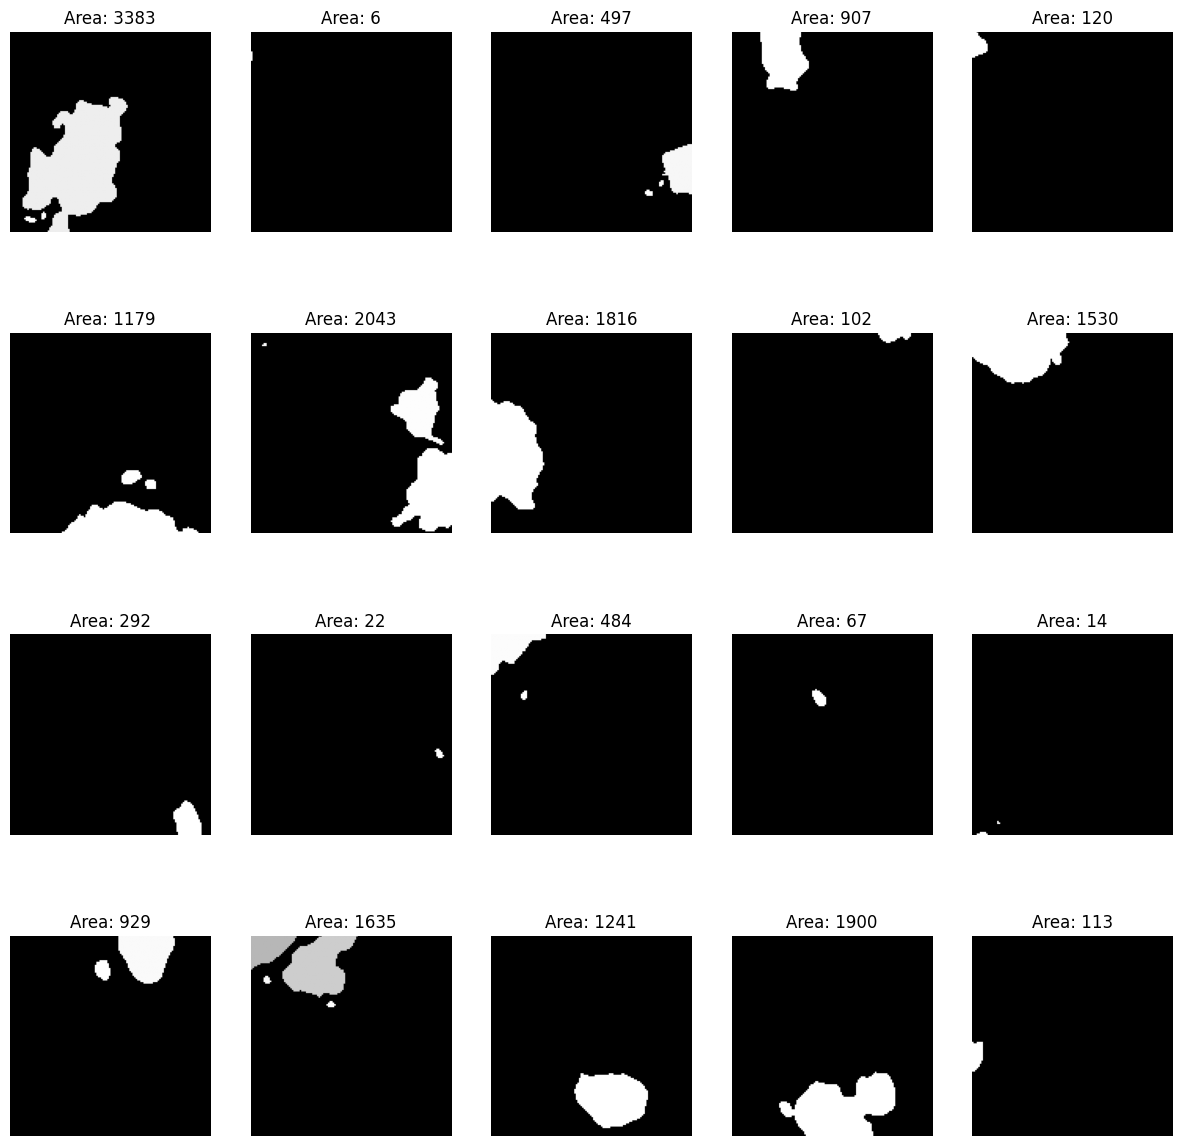

In [ ]:
# Choose 5 patches with non-zero area for each image and plot them
import matplotlib.pyplot as plt

# Set the number of patches to plot
n_patches = 5

# Plot the patches
fig, axes = plt.subplots(nrows=len(areas), ncols=n_patches, figsize=(15, 15))
axes = np.atleast_2d(axes)  # Ensure axes is 2D for consistent indexing

for i, key in enumerate(areas.keys()):
    non_zero_indices = np.where(np.array(areas[key]) > 0)[0]
    chosen_indices = random.sample(list(non_zero_indices), n_patches)
    for j, idx in enumerate(chosen_indices):
        axes[i, j].imshow(patches[key][idx], cmap="gray")
        axes[i, j].set_title(f"Area: {areas[key][idx]}")
        axes[i, j].axis("off")
    axes[i, 0].set_ylabel(key, rotation=0, size="large", labelpad=50)

## Graph Construction

In [ ]:
import torch
import scipy.sparse
from torch_geometric.data import Data
import numpy as np
from tqdm import tqdm

def create_graph_data_dict(adatas, areas, neighbors, cell_coords):
    """
    Create a dictionary of PyTorch Geometric Data objects from AnnData objects.
    
    Parameters:
    - adatas: dict of AnnData objects
    - areas: dict of patch areas
    - neighbors: dict of connectivity matrices
    - cell_coords: dict of spatial coordinates
    
    Returns:
    - graph_data_dict: dict of PyTorch Geometric Data objects
    """
    graph_data_dict = {}

    for key in tqdm(adatas.keys(), desc="Creating graph data"):
        # Ensure the keys match between adata and patches
        if key not in areas:
            print(f"Warning: No patch area data for {key}. Skipping.")
            continue

        adata = adatas[key]
        num_cells = adata.n_obs

        # Features: Gene expression data
        # Assuming 'X' is already a NumPy array after preprocessing
        features = adata.X
        if isinstance(features, scipy.sparse.csr_matrix):
            features = features.toarray()
        features = torch.tensor(features, dtype=torch.float)

        # Labels: Patch areas
        label_areas = areas[key]
        if len(label_areas) != num_cells:
            print(f"Warning: Number of patches and cells do not match for {key}.")
            # Handle mismatch, e.g., by trimming or padding
            min_len = min(len(label_areas), num_cells)
            label_areas = label_areas[:min_len]
            features = features[:min_len]

        labels = torch.tensor(label_areas, dtype=torch.float).unsqueeze(1)  # Shape: [num_nodes, 1]

        # Edges: Connectivity matrix
        connectivity = neighbors[key].tocoo()

        # Efficiently convert the edge matrix to tensor
        edge_index = torch.tensor(np.vstack([connectivity.row, connectivity.col]), dtype=torch.long)

        # Create PyTorch Geometric Data object
        data = Data(x=features, edge_index=edge_index, y=labels)

        # Optionally, add additional information (e.g., spatial coordinates)
        # spatial = torch.tensor(cell_coords[key], dtype=torch.float)
        # data.pos = spatial

        # Add to the dictionary
        graph_data_dict[key] = data

    return graph_data_dict


# Create the graph dictionary
graph_data_dict = create_graph_data_dict(adatas, areas, neighbors, cell_coords)


# Efficiently convert patches to tensors in batch
for key, graph in tqdm(graph_data_dict.items(), desc="Adding patches to graph data"):
    # Ensure patches[key] is a list of NumPy arrays
    patches_tensor = torch.tensor(np.array(patches[key]), dtype=torch.float)  # Convert patches to a single tensor efficiently
    graph.patches = patches_tensor



Adding patches to graph data: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


In [ ]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 131356], y=[8186, 1], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 167278], y=[10372, 1], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 132328], y=[8202, 1], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 155576], y=[9634, 1], patches=[9634, 128, 128, 1])}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
# Check system's gpu info
!nvidia-smi


Mon Dec 23 17:16:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:1F:00.0 Off |                    0 |
| N/A   30C    P0              50W / 350W |      3MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
torch.version.cuda

'12.4'

# Prediction & Represenation of the graph

In [263]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool


In [264]:
test_replicate_name = '13months-disease-replicate_2'


In [265]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_val_datalist = []
test_data = None

for name, raw_data in graph_data_dict.items():
    data = raw_data.clone()
    data.y = (data.y > 0).float()  # Binarize

    if name == test_replicate_name:
        # This entire graph is our final test set.
        test_data = data
    else:
        # We do random node-level splits for training & validation
        num_nodes = data.x.size(0)
        perm = torch.randperm(num_nodes)

        train_cutoff = int(0.8 * num_nodes)
        val_cutoff   = int(0.9 * num_nodes)

        data.train_idx = perm[:train_cutoff]
        data.val_idx   = perm[train_cutoff:val_cutoff]
        data.mini_test_idx = perm[val_cutoff:]  # optional mini-test

        train_val_datalist.append(data)

# Move test_data to device
test_data = test_data.to(device)


In [266]:
class GNNClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1, residual=True, dropout=0.5):
        super().__init__()
        
        # -- GCN Layer --
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        
        # -- GraphSAGE Layer --
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)

        # Optional skip connection parameter
        self.residual = residual

        # -- Final MLP block --
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_channels, out_channels)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch=None):
        # --- First layer: GCN ---
        out1 = self.conv1(x, edge_index)
        out1 = self.bn1(out1)
        out1 = F.relu(out1)
        out1 = self.dropout(out1)
        
        # --- Second layer: GraphSAGE ---
        out2 = self.conv2(out1, edge_index)
        out2 = self.bn2(out2)
        out2 = F.relu(out2)
        out2 = self.dropout(out2)
        
        # --- Residual Connection (optional) ---
        if self.residual:
            out2 = out1 + out2  # Skip connection

        # If graph-level classification, you'd pool here:
        #   out2 = global_mean_pool(out2, batch)
        # But for node-level, we skip global pooling.

        # --- Final MLP (per node) ---
        out = self.mlp(out2)

        return out


In [267]:
def weights_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


criterion = nn.BCEWithLogitsLoss()

def train_classifier(model, optimizer, datalist):
    """ Train on the 'train_idx' of each graph in datalist. """
    model.train()
    optimizer.zero_grad()
    total_loss = 0.0
    
    for data in datalist:
        data = data.to(device)
        out = model(data.x, data.edge_index).squeeze()  # shape: [num_nodes]
        
        train_labels = data.y[data.train_idx].view(-1)
        train_preds  = out[data.train_idx]              # shape: [num_train_nodes]
        
        loss = criterion(train_preds, train_labels)
        loss.backward()
        total_loss += loss.item()
    
    # Single optimizer step for all graphs combined
    optimizer.step()
    return total_loss / len(datalist)


@torch.no_grad()
def evaluate_classifier(model, datalist, split="val_idx"):
    """
    Evaluate the model on the given split of each graph in datalist.
    Return average (loss, accuracy, AUC) across all graphs.
    """
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_nodes   = 0
    all_labels    = []
    all_scores    = []
    
    for data in datalist:
        data = data.to(device)
        out = model(data.x, data.edge_index).squeeze()
        
        idx = getattr(data, split)  # e.g. data.val_idx
        labels = data.y[idx].view(-1)
        preds  = out[idx]
        
        # BCEWithLogitsLoss
        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        # Accuracy
        prob = torch.sigmoid(preds)
        binary_pred = (prob > 0.5).float()
        correct = (binary_pred == labels).sum().item()
        
        total_correct += correct
        total_nodes   += len(labels)
        
        # For AUC
        all_labels.append(labels.cpu())
        all_scores.append(prob.cpu())
    
    avg_loss = total_loss / len(datalist)
    avg_acc  = total_correct / total_nodes
    
    # Compute AUC across all graphs combined
    all_labels = torch.cat(all_labels, dim=0).numpy()
    all_scores = torch.cat(all_scores, dim=0).numpy()
    try:
        auc = roc_auc_score(all_labels, all_scores)
    except ValueError:
        # If all labels are 0 or 1, AUC can be undefined
        auc = float('nan')
    
    return avg_loss, avg_acc, auc


In [268]:
in_channels = train_val_datalist[0].x.size(1)

model = GNNClassifier(
    in_channels=in_channels,
    hidden_channels=128,
    dropout=0.6
).to(device)

model.apply(weights_init)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


Training on multiple graphs: 100%|██████████| 1000/1000 [00:21<00:00, 47.19it/s]


Best validation accuracy: 0.9357


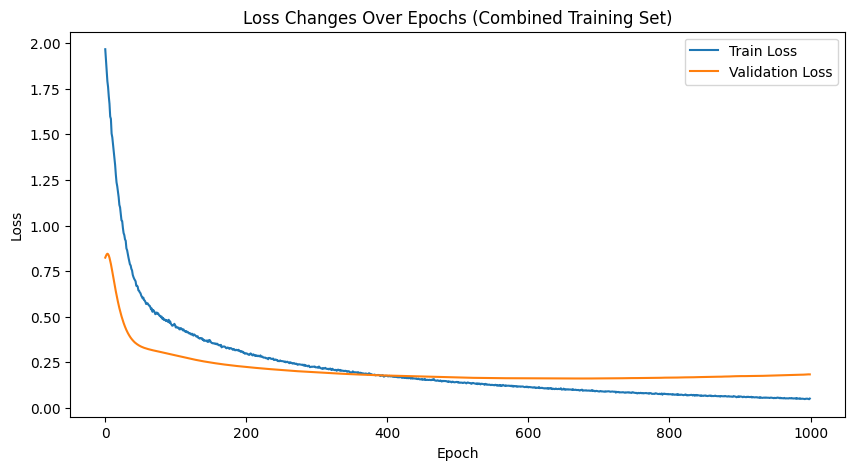

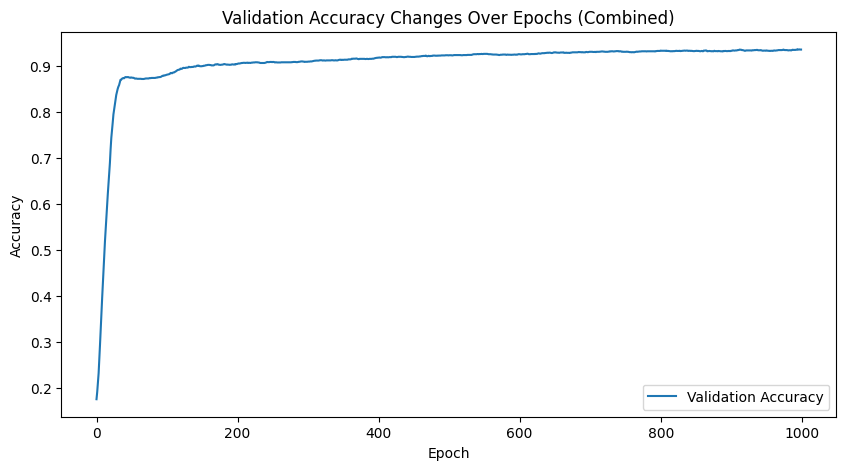

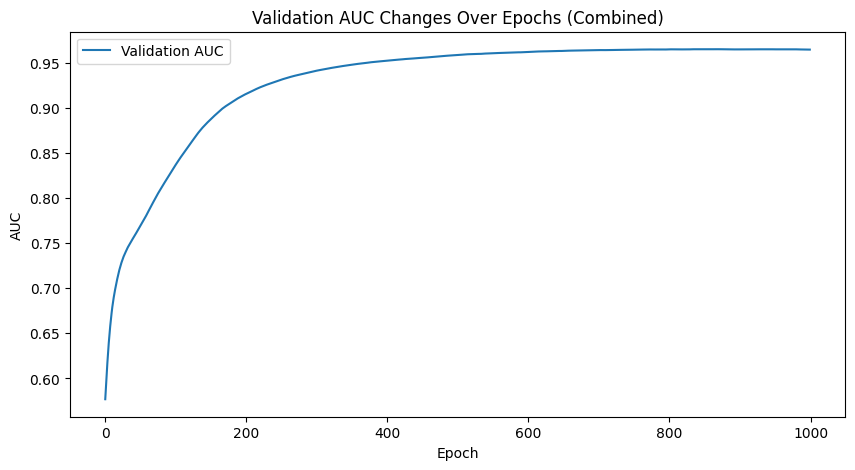

In [269]:
best_val_acc = 0.0
best_state = None

train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []

EPOCHS = 1000
for epoch in tqdm(range(EPOCHS), desc="Training on multiple graphs"):
    # 1) Train step (all training graphs)
    train_loss = train_classifier(model, optimizer, train_val_datalist)
    train_losses.append(train_loss)

    # 2) Validation step (all training graphs)
    val_loss, val_acc, val_auc = evaluate_classifier(model, train_val_datalist, split="val_idx")
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_aucs.append(val_auc)

    # Track best model by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict()

# Reload best model
if best_state is not None:
    model.load_state_dict(best_state)

print(f"Best validation accuracy: {best_val_acc:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Changes Over Epochs (Combined Training Set)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy Changes Over Epochs (Combined)')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation AUC Changes Over Epochs (Combined)')
plt.show()



In [271]:
@torch.no_grad()
def test_on_withheld_graph(model, data):
    model.eval()
    data = data.to(device)
    
    logits = model(data.x, data.edge_index).squeeze()
    labels = data.y.view(-1)
    
    loss = criterion(logits, labels).item()
    probs = torch.sigmoid(logits)
    binary_pred = (probs > 0.5).float()
    
    correct = (binary_pred == labels).sum().item()
    acc = correct / labels.size(0)
    
    try:
        auc = roc_auc_score(labels.cpu(), probs.cpu())
    except ValueError:
        auc = float('nan')
    
    return loss, acc, auc

test_loss, test_acc, test_auc = test_on_withheld_graph(model, test_data)
print(f"\n=== Final Test on '{test_replicate_name}' ===")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} | Test AUC: {test_auc:.4f}")



=== Final Test on '13months-disease-replicate_2' ===
Test Loss: 0.3930 | Test Accuracy: 0.9099 | Test AUC: 0.8359


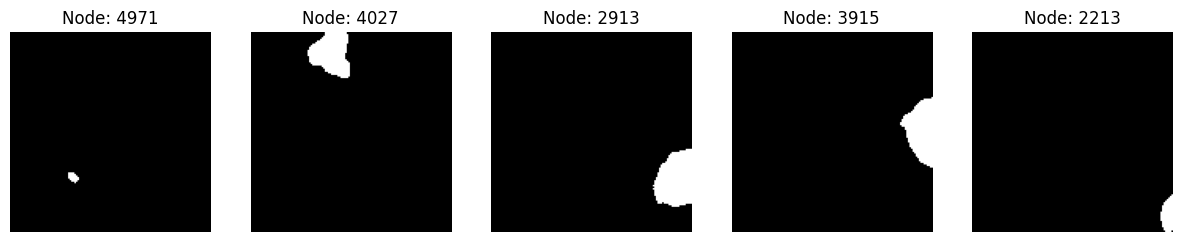

In [230]:
# Get predictions from the classifier
model.eval()
data = graph_data_dict['8months-disease-replicate_1'].clone().to(device)
with torch.no_grad():
    logits = model(data.x, data.edge_index).squeeze()
    preds = (logits.sigmoid() > 0.5).float()

# Identify positive nodes
positive_nodes = (preds == 1).nonzero(as_tuple=True)[0]

# Visualize a subset of the positive nodes' patches images
num_images_to_plot = min(5, len(positive_nodes))  # Plot up to 5 images
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))
axes = np.atleast_1d(axes)

# Randomly select positive nodes to plot
random_positive_nodes = random.sample(list(positive_nodes), num_images_to_plot)

for i, node in enumerate(random_positive_nodes):
    patch = data.patches[node].squeeze().to("cpu").numpy()
    axes[i].imshow(patch, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Node: {node.item()}")
plt.show()


In [224]:
len(positive_nodes)

782

In [234]:
sum(data.y > 0)

tensor([827], device='cuda:0')

# Train diffusion model

In [319]:
# Get predictions from the classifier
positive_nodes_dict = {}

model.eval()
for key, data in graph_data_dict.items():
    data = data.clone().to(device)
    with torch.no_grad():
        logits = model(data.x, data.edge_index).squeeze()
        preds = (logits.sigmoid() > 0.5).float()

    # Identify positive nodes
    positive_nodes = (preds == 1).nonzero(as_tuple=True)[0].cpu()
    positive_nodes_dict[key] = positive_nodes


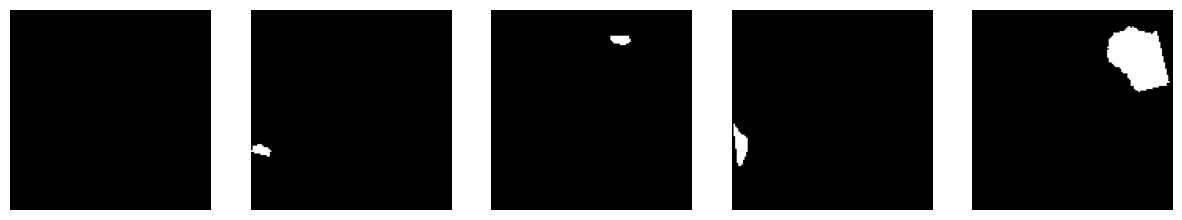

In [349]:
# Import transform functions from torchvision
from torchvision.transforms import transforms

# Create a dataset of only positive patches
class PositivePatchDataset(Dataset):
    def __init__(self, patches, device):
        self.patches = patches.to(device)
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
        ])

    def __len__(self):
        return self.patches.size(0)

    def __getitem__(self, idx):
        patch = self.patches[idx]  # [1,128,128]
        # Convert to PIL and back to tensor for augmentations
        patch_np = (patch.squeeze(0).cpu().numpy() * 255).astype(np.uint8)
        # Now apply transforms
        patch_pil = transforms.ToPILImage()(patch_np)
        patch_pil = self.transform(patch_pil)
        patch_tensor = transforms.ToTensor()(patch_pil).to(self.patches.device)  # [1,128,128], float in [0,1]
        return patch_tensor
    
# Filter for positive nodes
positive_patches_dict = {}
for key, data in graph_data_dict.items():
    positive_nodes = positive_nodes_dict[key]
    positive_patches = data.patches[positive_nodes]
    positive_patches_dict[key] = positive_patches

# Combine all positive patches into a single tensor
all_positive_patches = torch.cat(list(positive_patches_dict.values()), dim=0)
positive_dataset = PositivePatchDataset(all_positive_patches, device)
plaque_loader = DataLoader(positive_dataset, batch_size=32, shuffle=True)

# Visualize a subset of the positive patches
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))
axes = np.atleast_1d(axes)

for i in range(num_images_to_plot):
    patch = positive_dataset[i].squeeze().to("cpu").numpy()
    axes[i].imshow(patch, cmap='gray')
    axes[i].axis('off')
plt.show()



In [362]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 32  # the batch size for training
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 200
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "diffusion_project/diffusers_trial"  # the model name locally and on the HF Hub

    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [363]:
from diffusers import UNet2DModel

diffu_model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
).to(device)

In [364]:
sample_image = positive_dataset[100].unsqueeze(0).to(device)
print("Input shape:", sample_image.shape)
print("Output shape:", diffu_model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 1, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])


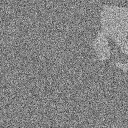

In [365]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).cpu().numpy()[0].squeeze(2))

In [366]:
import torch.nn.functional as F

noise_pred = diffu_model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [367]:
loss

tensor(1.3170, device='cuda:0', grad_fn=<MseLossBackward0>)

## Train the model

In [368]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(diffu_model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(plaque_loader) * config.num_epochs),
)

In [369]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device=device).manual_seed(config.seed), # Use a separate torch generator to avoid rewinding the random state of the main training loop
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [370]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    loss_values = []  # Initialize a list to store loss values
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                loss_values.append(loss.detach().item())  # Append the loss value

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

    if accelerator.is_main_process:
        plt.figure(figsize=(10, 6))
        plt.plot(loss_values, label="Loss")
        plt.xlabel("Steps")
        plt.ylabel("Loss")
        plt.title("Training Loss Curve")
        plt.legend()
        plt.grid()
        plt.show()

In [371]:
from accelerate import notebook_launcher

args = (config, diffu_model, noise_scheduler, optimizer, plaque_loader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

/public/home/jijh/micromamba/envs/gpu_env/lib/python3.12/site-packages/accelerate/accelerator.py:453: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Launching training on one GPU.


Epoch 56: 100%|██████████| 149/149 [00:26<00:00,  5.60it/s, loss=0.000432, lr=8.27e-5, step=8492]

Epoch 57:  11%|█▏        | 17/149 [00:03<00:24,  5.50it/s, loss=0.000584, lr=8.27e-5, step=8509]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [372]:
# Clean up the cuda cache
torch.cuda.empty_cache()

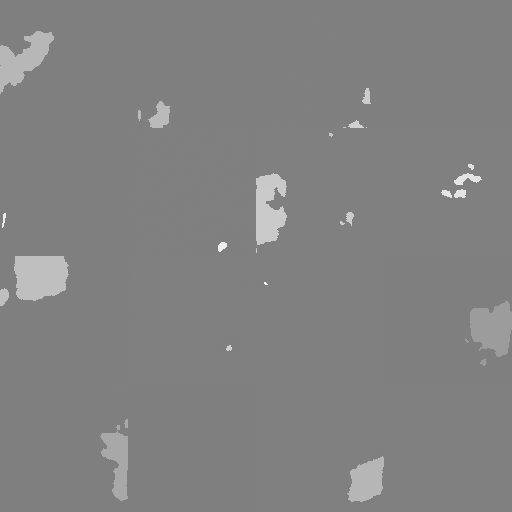

In [373]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

100%|██████████| 1000/1000 [00:26<00:00, 37.68it/s]


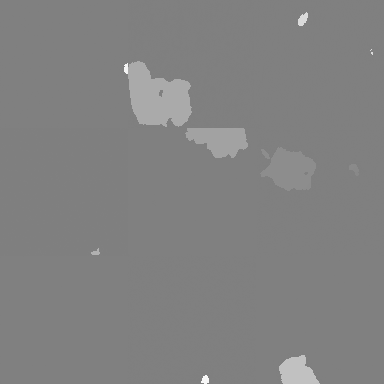

In [382]:
# Generate images from the trained model
pipeline = DDPMPipeline(unet=diffu_model, scheduler=noise_scheduler, )
images = pipeline(batch_size=9).images

# Make a grid out of the images
image_grid = make_image_grid(images, rows=3, cols=3)
image_grid



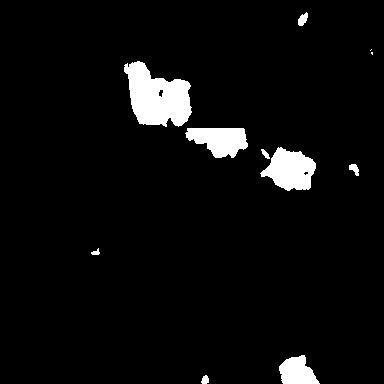

In [384]:
# Binarize the images
binarized_images = [image.point(lambda x: 0 if x < 130 else 255) for image in images]
binarized_image_grid = make_image_grid(binarized_images, rows=3, cols=3)
binarized_image_grid

In [294]:
graph_data_dict

{'8months-disease-replicate_1': Data(x=[8186, 2766], edge_index=[2, 131356], y=[8186, 1], patches=[8186, 128, 128, 1]),
 '13months-disease-replicate_1': Data(x=[10372, 2766], edge_index=[2, 167278], y=[10372, 1], patches=[10372, 128, 128, 1]),
 '8months-disease-replicate_2': Data(x=[8202, 2766], edge_index=[2, 132328], y=[8202, 1], patches=[8202, 128, 128, 1]),
 '13months-disease-replicate_2': Data(x=[9634, 2766], edge_index=[2, 155576], y=[9634, 1], patches=[9634, 128, 128, 1])}

# Conditioned diffusion model

In [484]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import VGAE
from torch_geometric.data import Data, Dataset, DataLoader
import numpy as np
from torchvision.transforms import transforms
from diffusers import UNet2DConditionModel, DDPMScheduler, DDPMPipeline
from dataclasses import dataclass
from accelerate import Accelerator
from diffusers.optimization import get_cosine_schedule_with_warmup
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [485]:
###############################################################################
# 1) Deeper VGAE: multi-layer GCN encoder + simple inner-product decoder
###############################################################################

class DeeperGCNEncoder(torch.nn.Module):
    """
    A deeper GCN encoder for a VGAE:
      - 3 GCN layers + ReLU + dropout
      - final layers produce mu, logvar of dimension `latent_dim`
    """
    def __init__(self, in_channels, hidden_channels, latent_dim, dropout=0.2):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.conv_mu = GCNConv(hidden_channels, latent_dim)
        self.conv_logvar = GCNConv(hidden_channels, latent_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)  # 1st GCN
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv2(x, edge_index)  # 2nd GCN
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.conv3(x, edge_index)  # 3rd GCN
        x = F.relu(x)
        # no dropout here (optional)

        # Mean & logvar
        mu = self.conv_mu(x, edge_index)
        logvar = self.conv_logvar(x, edge_index)
        return mu, logvar

class SimpleGAEDecoder(torch.nn.Module):
    """
    Decoder that reconstructs adjacency from node embeddings z via inner product.
    """
    def forward(self, z):
        return torch.sigmoid(torch.matmul(z, z.t()))

class DeeperVGAE(VGAE):
    """
    A deeper VGAE model with custom encoder and manual reparameterization.
    Stores mu and logvar as attributes for easy access.
    """
    def __init__(self, in_channels, hidden_channels, latent_dim, dropout=0.2):
        super().__init__(
            encoder=DeeperGCNEncoder(in_channels, hidden_channels, latent_dim, dropout),
            decoder=SimpleGAEDecoder()
        )
        self.mu = None
        self.logvar = None

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def encode(self, x, edge_index):
        mu, logvar = self.encoder(x, edge_index)
        z = self.reparameterize(mu, logvar)
        self.mu = mu
        self.logvar = logvar
        return z


In [486]:

###############################################################################
# 3) VGAE training function
###############################################################################

def train_vgae_on_graph(graph_data, vgae, optimizer, epochs=40, kl_annealing_epochs=20):
    """
    Trains a VGAE on a single PyG Data object for adjacency reconstruction.
    Returns the final node embeddings z.

    Args:
        graph_data: a PyG Data object (with data.x, data.edge_index).
        vgae: a DeeperVGAE model.
        optimizer: torch optimizer
        epochs: how many epochs to train
        kl_annealing_epochs: how many epochs to reach full KL weight
    """
    data = graph_data.to(device)
    num_nodes = data.num_nodes
    ei = data.edge_index

    # Build dense adjacency for reconstruction loss (for smaller graphs).
    # For large graphs, switch to a more memory-friendly approach.
    adj = torch.zeros((num_nodes, num_nodes), device=device)
    adj[ei[0], ei[1]] = 1.0
    adj[ei[1], ei[0]] = 1.0  # assume undirected

    vgae.train()
    for epoch in range(epochs):
        optimizer.zero_grad()

        # 1) forward pass => z, then decode adjacency
        z = vgae.encode(data.x, data.edge_index)  # calls encode(...) => sets vgae.mu/logvar
        adj_pred = vgae.decoder(z)                # [num_nodes, num_nodes] in [0,1]

        # 2) recon loss
        recon_loss = F.binary_cross_entropy(adj_pred, adj)

        # 3) KLD (like standard VAE)
        mu, logvar = vgae.mu, vgae.logvar
        # standard formula: KL = -0.5 * \sum(1 + logvar - mu^2 - e^{logvar})
        kl_nodes = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
        kl_mean = kl_nodes.mean()

        # 4) KL weight (annealing if desired)
        kl_weight = min(1.0, epoch / kl_annealing_epochs)

        loss = recon_loss + kl_weight * kl_mean
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 5 == 0:
            print(f"[VGAE] Epoch {epoch+1}/{epochs} | Recon: {recon_loss.item():.4f} | KL: {kl_mean.item():.4f} | KL_w: {kl_weight:.2f}")

    # Final embeddings
    vgae.eval()
    with torch.no_grad():
        z = vgae.encode(data.x, data.edge_index)  # [num_nodes, latent_dim]
    return z

In [487]:
###############################################################################
# 4) Conditioned dataset: returns (patch, node_embedding)
###############################################################################

class ConditionedPatchDataset(Dataset):
    """
    This dataset:
      - stores patches: [N, 128,128,1]
      - stores node_embeddings: [N, cond_dim]
      - applies optional image transformations
      - returns (patch_tensor, cond_tensor)
    """
    def __init__(self, patches, node_embeddings, device):
        super().__init__()
        self.patches = patches        # shape [N, 128,128,1] or [N,128,128]
        self.node_embeddings = node_embeddings
        self.device = device
        
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
        ])

    def __len__(self):
        return self.patches.size(0)

    def __getitem__(self, idx):
        # 1) Patch
        patch = self.patches[idx]  # e.g. [128,128,1]
        if patch.dim() == 3 and patch.shape[-1] == 1:
            # => shape [128,128,1], permute to [1,128,128]
            patch = patch.permute(2, 0, 1)  # [1,128,128]
        elif patch.dim() == 3 and patch.shape[0] == 1:
            # shape [1,128,128], already good
            pass

        # Convert to PIL for augmentations
        patch_np = (patch.squeeze(0).cpu().numpy() * 255).astype(np.uint8)  # [128,128]
        patch_pil = transforms.ToPILImage()(patch_np)
        patch_pil = self.transform(patch_pil)

        # Back to Tensor
        patch_tensor = transforms.ToTensor()(patch_pil)  # => [1,128,128], float in [0,1]

        # 2) Condition (node embedding)
        cond_vec = self.node_embeddings[idx]  # shape [cond_dim]

        return patch_tensor, cond_vec

In [492]:
###############################################################################
# 5) Conditional diffusion setup
###############################################################################

@dataclass
class TrainingConfig:
    image_size: int = 128
    train_batch_size: int = 32
    eval_batch_size: int = 16
    num_epochs: int = 100
    gradient_accumulation_steps: int = 1
    learning_rate: float = 1e-4
    lr_warmup_steps: int = 500
    save_image_epochs: int = 2
    save_model_epochs: int = 2
    mixed_precision: str = "fp16"  # "no" or "fp16"
    output_dir: str = "./diffusion_conditional_output"
    push_to_hub: bool = False
    hub_model_id: str = "user/conditional-model"
    hub_private_repo: bool = False
    overwrite_output_dir: bool = True
    seed: int = 0

COND_DIM = 256  # Embedding dimension from VGAE

def create_conditional_unet(cond_dim=COND_DIM):
    model = UNet2DConditionModel(
        sample_size=128,        # image resolution
        in_channels=1,          # grayscale input
        out_channels=1,         # grayscale output
        layers_per_block=2,
        block_out_channels=(128, 128, 256, 256, 512, 512),
        down_block_types=(
            "DownBlock2D",
            "DownBlock2D",
            "DownBlock2D",
            "DownBlock2D",
            "AttnDownBlock2D",
            "DownBlock2D",
        ),
        up_block_types=(
            "UpBlock2D",
            "AttnUpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
            "UpBlock2D",
        ),
        cross_attention_dim=cond_dim,  
    )
    return model

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [493]:
###############################################################################
# 6) Diffusion training loop
###############################################################################

def evaluate(config, epoch, pipeline, accelerator):
    """
    Generate a grid of images using random embeddings as condition.
    In practice, you might want to feed real node embeddings or specialized ones.
    """
    cond_dim = pipeline.unet.config.cross_attention_dim
    random_condition = torch.randn((config.eval_batch_size, cond_dim), device=accelerator.device)
    
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.Generator(device=accelerator.device).manual_seed(config.seed),
        encoder_hidden_states=random_condition,
    ).images

    from diffusers.utils import make_image_grid
    image_grid = make_image_grid(images, rows=4, cols=4)
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        project_dir=os.path.join(config.output_dir, "logs"),
    )

    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0
    loss_values = []

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        model.train()
        for step, (clean_images, conditions) in enumerate(train_dataloader):
            clean_images = clean_images.to(accelerator.device, dtype=torch.float32)
            conditions = conditions.to(accelerator.device, dtype=torch.float32)

            # 1) Sample noise
            noise = torch.randn_like(clean_images)
            bs = clean_images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device)

            # 2) Forward diffusion
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # 3) Predict noise, with cross-attention
                noise_pred = model(
                    noisy_images,
                    timesteps,
                    encoder_hidden_states=conditions.unsqueeze(1),  # [B, 1, cond_dim]
                ).sample

                # 4) Loss
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                loss_values.append(loss.item())
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                "loss": loss.item(),
                "lr": lr_scheduler.get_last_lr()[0],
                "step": global_step
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # Optionally save model or do custom "evaluation" after each epoch
        if accelerator.is_main_process:
            # Save the model if you like
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                unwrapped = accelerator.unwrap_model(model)
                unwrapped.save_pretrained(config.output_dir)

    # Plot training curve
    if accelerator.is_main_process:
        plt.figure(figsize=(10, 6))
        plt.plot(loss_values)
        plt.title("Training Loss")
        plt.xlabel("Step")
        plt.ylabel("MSE Loss")
        plt.grid(True)
        plt.show()



In [494]:
###############################################################################
# 8) Custom Sampling Loop
###############################################################################
@torch.no_grad()
def sample_conditioned_ddpm(
    unet,
    scheduler,
    batch_size,
    cond_vectors,      # shape [batch_size, 1, cond_dim]
    device,
    num_inference_steps=50
):
    """
    Manually sample images from a DDPM using a condition vector
    (shape: [batch_size, 1, cond_dim]) for cross-attention.
    """
    # 1) Start from pure noise
    sample = torch.randn(
        batch_size,
        unet.config.in_channels,
        unet.config.sample_size,
        unet.config.sample_size,
        device=device
    )

    # 2) Set inference schedule
    scheduler.set_timesteps(num_inference_steps, device=device)

    # 3) Reverse diffusion loop
    for i, t in enumerate(scheduler.timesteps):
        noise_pred = unet(
            sample,
            t,
            encoder_hidden_states=cond_vectors,
        ).sample

        sample = scheduler.step(noise_pred, t, sample).prev_sample
        # sample shape remains [B,1,128,128]

    return sample  # [B, 1, H, W]

In [495]:
################################################################################
# 9) Putting it all together
################################################################################


config = TrainingConfig()

# (A) We'll gather all node embeddings (for the entire graph) but 
#     ONLY keep the "positive" nodes in the final diffusion dataset.
all_pos_embeddings = []
all_pos_patches = []

for key, data in graph_data_dict.items():
    print(f"\n=== Training VGAE on full graph: {key} ===")

    # 1) Create and train the DeeperVGAE
    vgae_model = DeeperVGAE(
        in_channels=data.x.size(1),   # e.g. 2766
        hidden_channels=512,
        latent_dim=COND_DIM
    ).to(device)
    optimizer_vgae = torch.optim.Adam(vgae_model.parameters(), lr=1e-3)

    node_embeddings = train_vgae_on_graph(
        graph_data=data,
        vgae=vgae_model,
        optimizer=optimizer_vgae,
        epochs=20
    )  # shape [num_nodes, COND_DIM]

    # 2) Filter out the positive nodes only
    positive_nodes = positive_nodes_dict[key]  # e.g. a tensor of shape [K]
    pos_z = node_embeddings[positive_nodes]    # [K, COND_DIM]
    pos_patches = data.patches[positive_nodes] # [K, 128,128,1]

    # 3) Accumulate
    all_pos_embeddings.append(pos_z.cpu())
    all_pos_patches.append(pos_patches.cpu())

# Combine across all graphs
all_pos_embeddings = torch.cat(all_pos_embeddings, dim=0)  # [total_pos_nodes, COND_DIM]
all_pos_patches = torch.cat(all_pos_patches, dim=0)        # [total_pos_nodes, 128,128,1]


=== Training VGAE on full graph: 8months-disease-replicate_1 ===
[VGAE] Epoch 5/20 | Recon: 16.9416 | KL: 0.3337 | KL_w: 0.20
[VGAE] Epoch 10/20 | Recon: 16.8956 | KL: 0.1260 | KL_w: 0.45
[VGAE] Epoch 15/20 | Recon: 17.0087 | KL: 0.0523 | KL_w: 0.70
[VGAE] Epoch 20/20 | Recon: 17.1230 | KL: 0.0306 | KL_w: 0.95

=== Training VGAE on full graph: 13months-disease-replicate_1 ===
[VGAE] Epoch 5/20 | Recon: 16.5780 | KL: 0.5047 | KL_w: 0.20
[VGAE] Epoch 10/20 | Recon: 16.7571 | KL: 0.1473 | KL_w: 0.45
[VGAE] Epoch 15/20 | Recon: 17.0257 | KL: 0.0587 | KL_w: 0.70
[VGAE] Epoch 20/20 | Recon: 17.0612 | KL: 0.0333 | KL_w: 0.95

=== Training VGAE on full graph: 8months-disease-replicate_2 ===
[VGAE] Epoch 5/20 | Recon: 16.7750 | KL: 0.3987 | KL_w: 0.20
[VGAE] Epoch 10/20 | Recon: 16.7678 | KL: 0.1377 | KL_w: 0.45
[VGAE] Epoch 15/20 | Recon: 17.0746 | KL: 0.0465 | KL_w: 0.70
[VGAE] Epoch 20/20 | Recon: 17.0937 | KL: 0.0283 | KL_w: 0.95

=== Training VGAE on full graph: 13months-disease-replicate

In [496]:
# (B) Build the ConditionedPatchDataset and DataLoader
dataset = ConditionedPatchDataset(all_pos_patches, all_pos_embeddings, device=torch.device("cpu"))
train_loader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)


In [497]:
# (C) Create the conditional UNet + optimizer + scheduler
diffu_model = create_conditional_unet(cond_dim=COND_DIM).to(device)
optimizer = torch.optim.AdamW(diffu_model.parameters(), lr=config.learning_rate)

num_training_steps = len(train_loader) * config.num_epochs
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=num_training_steps,
)


In [498]:
# (D) Train the diffusion model
train_loop(config, diffu_model, noise_scheduler, optimizer, train_loader, lr_scheduler)

print("\n>>> Conditional Diffusion Training Complete <<<")

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Epoch 98: 100%|██████████| 149/149 [00:27<00:00,  5.46it/s, loss=0.00161, lr=2.68e-8, step=14750] 


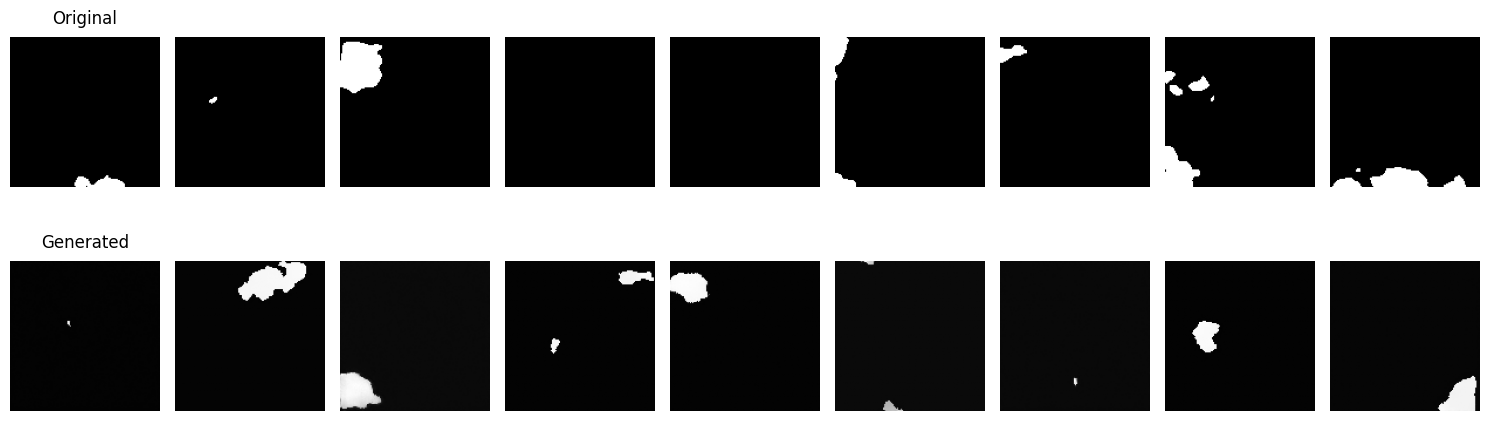

In [505]:
# (E) Compare the conditioned generated samples using nodes emedding with the original patches
diffu_model.eval()
with torch.no_grad():
    # Sample selection
    num_samples = 9
    sample_indices = torch.randperm(all_pos_embeddings.size(0))[:num_samples]
    
    # Move embeddings to correct device
    sample_embeddings = all_pos_embeddings[sample_indices].to(device)
    original_patches = all_pos_patches[sample_indices].to(device)
    
    # Ensure condition vectors are correctly shaped and on device
    condition_input = sample_embeddings.unsqueeze(1).to(device)  # [B, 1, COND_DIM]
    
    # Generate samples with device-aware inputs
    generated_samples = sample_conditioned_ddpm(
        unet=accelerator.unwrap_model(diffu_model),
        scheduler=noise_scheduler,
        batch_size=num_samples,
        cond_vectors=condition_input,
        device=device,
        num_inference_steps=50
    )
    
    # Rest of visualization code...
    def prepare_for_display(tensor):
        tensor = tensor.cpu().detach()
        tensor = (tensor + 1) / 2
        tensor = torch.clamp(tensor, 0, 1)
        return tensor.numpy()

    # Process both sets of images
    original_np = prepare_for_display(original_patches)
    generated_np = prepare_for_display(generated_samples)
    
    if original_np.shape[1] == 1:
        original_np = original_np.squeeze(1)
    if generated_np.shape[1] == 1:
        generated_np = generated_np.squeeze(1)

    # Create comparison visualization
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    
    for i in range(num_samples):
        # Original patches
        axes[0,i].imshow(original_np[i], cmap='gray')
        axes[0,i].axis('off')
        if i == 0:
            axes[0,i].set_title('Original', pad=10)
            
        # Generated samples
        axes[1,i].imshow(generated_np[i], cmap='gray')
        axes[1,i].axis('off')
        if i == 0:
            axes[1,i].set_title('Generated', pad=10)
    
    plt.tight_layout()
    plt.show()
